In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image
import os
import scipy
import pandas as pd
import pickle
import re
import json

In [ ]:
"""from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image
import os
import scipy
import pandas as pd
import pickle
import json
import re"""

In [2]:
vgg_model = VGG16(weights='imagenet', include_top=False)

In [3]:
input_dir = "pokemon_card_images"  # Directory containing original images
output_dir = "cropped_images"      # Directory to store cropped images

In [4]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Open the image and ensure it's in RGB mode
    img = img.resize((224, 224))  # Resize the image to 224x224 (VGG16 input size)
    
    # Convert the image to an array and expand the dimensions (to match batch size of 1)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    
    # Preprocess the image for VGG16
    return preprocess_input(img_array)

def extract_features(image_path):
    preprocessed_img = preprocess_image(image_path)
    
    # Extract features using VGG16
    features = vgg_model.predict(preprocessed_img)
    
    # Flatten the output to a 1D array (if needed)
    features = features.flatten()
    
    return features


In [21]:
os.system('rm -rf cropped_images/')
os.makedirs(output_dir, exist_ok=True)

with open('pokemon_list.pkl', 'rb') as f:
    pokemon_list = pickle.load(f)

import re
delimiters ='-bs', '-ju-', '-fo-', '-tr', '-black', '-heroes','-challenge', '.jpg'
regex_pattern = '|'.join(map(re.escape, delimiters))
cards_list = []

def extract_name_and_number(filename):
    match = re.match(r"([a-zA-Z0-9\-]+)-(\d+)(\.jpg)$", filename)
    if match:
        return match.group(1), int(match.group(2))  # Return name and number as tuple
    return match, 0

cname_dict = {}

# Define the cropping box (left, upper, right, lower)
crop_box = (90, 65, 400, 320)  # Example: Cropping a rectangle from (100, 100) to (400, 500)
# List to store features of all images
features_list = []

# Loop through the images in the input directory
for filename in sorted(os.listdir(input_dir)):
    card_name = re.split(regex_pattern, filename)[0]
    cname, cnum = extract_name_and_number(filename)

    if cname is None:
        continue  # Skip invalid formats
    
    # Check if this name is already in the dictionary
    if cname in cname_dict:
        # Check if the number differs by 1 or is the same
        if any(abs(existing_num - cnum) == 1 or existing_num == cnum for existing_num in cname_dict[cname]):
            cname_dict[cname].append(cnum)  # Add the number to the list
        else:
            continue  # Skip adding this item, as no valid number difference was found
    else:
        # If the name isn't in the dictionary, add it with the number
        cname_dict[cname] = [cnum]

    #if card_name in cards_list:
    #    continue # no non-holo repeats this is failing with the neo sets now because neo not a delimeter but they have diff variations so ill allow for now
    if not any(pokemon in card_name for pokemon in pokemon_list):
        continue # non-pokemon cards some slip thru cracks like clefairy doll
    elif 'base-set-2' in filename or 'legendary-collection' in filename:
        continue #no bs2 and no lc
    else:
        cards_list.append(card_name)
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):  # Check for image formats
        image_path = os.path.join(input_dir, filename)
    
        
        try:
            # Open the image
            img = Image.open(image_path)
            
            # Crop the image
            cropped_img = img.crop(crop_box)
            
            # Save the cropped image
            cropped_path = os.path.join(output_dir, filename)
            cropped_img.save(cropped_path)  # Save the cropped image

            print(f"Cropped image saved: {filename}")
        
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue  # Skip the current image and move to the next one

        # Extract features from the cropped image (use actual image data here)
        print(f"Extracting features from {filename}...")
        features = extract_features(cropped_path)  # Pass the cropped image itself
        features_list.append(features)



with open('cards_list.pkl', 'wb') as f:
    pickle.dump(cards_list, f)

# Optionally, save the features to a CSV file
df = pd.DataFrame(features_list)
df.to_csv("vgg_features.csv", index=False)
print("Feature extraction completed and saved to vgg_features.csv.")

Cropped image saved: abra-base-set-bs-43.jpg
Extracting features from abra-base-set-bs-43.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Cropped image saved: abra-team-rocket-tr-49.jpg
Extracting features from abra-team-rocket-tr-49.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Cropped image saved: aerodactyl-fossil-fo-1.jpg
Extracting features from aerodactyl-fossil-fo-1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Cropped image saved: aerodactyl-neo-revelation-15.jpg
Extracting features from aerodactyl-neo-revelation-15.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Cropped image saved: aipom-neo-genesis-26.jpg
Extracting features from aipom-neo-genesis-26.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Cropped image saved: aipom-neo-revelation-41.jpg
Extracting features from aipom-neo-revelation-41.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Cropped image saved: alakazam-base-set-bs-1.jpg
Extracting features from alakazam-base-set-bs-1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Cr

In [5]:
features_csv = "vgg_features.csv"
features_list = pd.read_csv(features_csv)

with open('cards_list.pkl', 'rb') as f:
    cards_list = pickle.load(f)

# Assuming you have your extracted features stored in 'features_list' 
# as a NumPy array, one feature vector per image
features_array = np.array(features_list)

# Calculate the pairwise cosine similarity between all feature vectors
similarity_matrix = cosine_similarity(features_array)

# Print the similarity matrix (optional, as it can be large)
print("Cosine Similarity Matrix:")
print(similarity_matrix)

Cosine Similarity Matrix:
[[1.         0.24043344 0.22215733 ... 0.25546881 0.29861339 0.2535089 ]
 [0.24043344 1.         0.19729916 ... 0.30071971 0.28318816 0.27908093]
 [0.22215733 0.19729916 1.         ... 0.21318182 0.2180566  0.23192989]
 ...
 [0.25546881 0.30071971 0.21318182 ... 1.         0.34792077 0.29567642]
 [0.29861339 0.28318816 0.2180566  ... 0.34792077 1.         0.36621815]
 [0.2535089  0.27908093 0.23192989 ... 0.29567642 0.36621815 1.        ]]


In [6]:
# For Cosine Similarity
# Find the index of the maximum similarity (ignoring self-comparison)

np.fill_diagonal(similarity_matrix, 0)  # Set diagonal to 0 so it doesn't consider the image itself
most_similar_idx = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)
print(f"Most similar images are {cards_list[most_similar_idx[0]]} and {cards_list[most_similar_idx[1]]} with similarity {similarity_matrix[most_similar_idx]}")

Most similar images are pikachu-jungle and pikachu-wizards with similarity 0.5533104381116171


In [7]:

# Assuming you have your extracted features stored in 'features_list' 
# as a NumPy array, one feature vector per image
features_array = np.array(features_list)

# Calculate the pairwise cosine similarity between all feature vectors
similarity_matrix = cosine_similarity(features_array)

np.fill_diagonal(similarity_matrix, np.nan)  # Ignore self-similarity by setting diagonal to NaN
min_similarity = np.nanmin(similarity_matrix)  # Find the smallest similarity score
most_different_pair = np.unravel_index(np.nanargmin(similarity_matrix), similarity_matrix.shape)

# Step 3: Retrieve the names of the most different images
image_a = cards_list[most_different_pair[0]]
image_b = cards_list[most_different_pair[1]]

# Print the results
print(f"The most different images are:")
print(f"{image_a} and {image_b} with similarity score: {min_similarity:.4f}")

The most different images are:
dark-ursaring-neo-destiny-21 and unown-t-neo-destiny-88 with similarity score: 0.0753


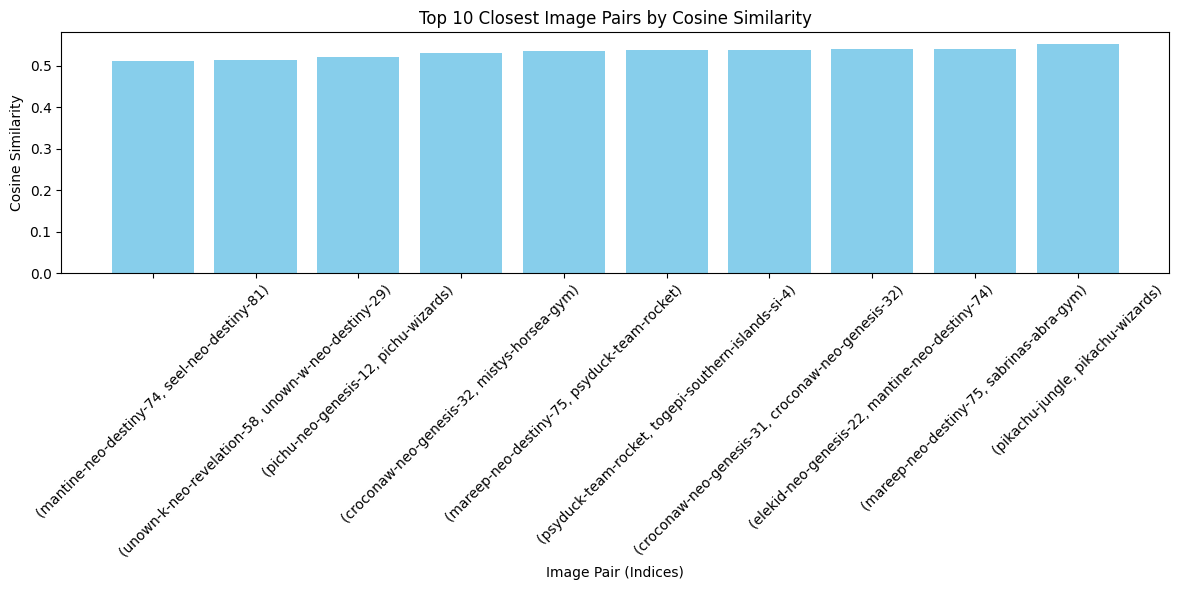

In [8]:
import matplotlib.pyplot as plt
tri_upper_indices = np.triu_indices(len(similarity_matrix), k=1)
cos_sim_values = similarity_matrix[tri_upper_indices]

# Get the indices of the 20 highest cosine similarities
top_10_indices = np.argsort(cos_sim_values)[-10:]

top_pairs = [(tri_upper_indices[0][idx], tri_upper_indices[1][idx]) for idx in top_10_indices]
top_sim_values = cos_sim_values[top_10_indices]

x_labels = [f"({cards_list[pair[0]]}, {cards_list[pair[1]]})" for pair in top_pairs]
#x_labels = [f"({pair[0]}, {pair[1]})" for pair in top_pairs]

# Step 5: Plot the cosine similarity values
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot for the top 10 cosine similarity values
ax.bar(range(10), top_sim_values, tick_label=x_labels, color='skyblue')

# Add labels and title
ax.set_xlabel('Image Pair (Indices)')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Top 10 Closest Image Pairs by Cosine Similarity')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import os
import base64
from PIL import Image
from io import BytesIO

# Path to your image directory
image_directory = "cropped_images"

# Get all image file paths from the directory
image_files = [os.path.join(image_directory, img) for img in sorted(os.listdir(image_directory)) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Ensure the number of images matches the number of nodes
num_nodes = len(image_files)

threshold = 0.42

# Assuming you already have a similarity matrix
# similarity_matrix = ...  # Your actual similarity matrix here

# Create graph
G = nx.Graph()
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Get positions using spring layout
pos = nx.spring_layout(G)

# Encode images in Base64
def encode_image(image_path):
    """Encode image as Base64 string."""
    with open(image_path, "rb") as img_file:
        encoded = base64.b64encode(img_file.read()).decode('ascii')
    return f"data:image/png;base64,{encoded}"

# Map images to nodes
node_images = [encode_image(img) for img in image_files]

# Create edge traces (no width based on similarity)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),  # Default edge width
    hoverinfo='none',
    mode='lines'
)

# Create the figure
fig = go.Figure()

# Add edges
fig.add_trace(edge_trace)

# Add images as node markers (translucent images)
for node in G.nodes():
    x, y = pos[node]
    fig.add_layout_image(
        dict(
            source=node_images[node],  # Use node to access the image from the list
            x=x,
            y=y,
            xref="x",
            yref="y",
            sizex=0.1,  # Initial size of the image
            sizey=0.1,
            xanchor="center",
            yanchor="middle",
            layer="above",
            opacity=0.6  # Set opacity for translucency (0 is fully transparent, 1 is fully opaque)
        )
    )

# Set layout
fig.update_layout(
    title='Network Diagram with Images as Nodes',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    height=800,
    width=1600,
)

fig.show()


In [10]:
# Keyword to search
keyword = input("Enter a keyword to search: ")

# Find exact match first
exact_match = next((entry for entry in cards_list if keyword in entry.lower()), None)

# If no exact match, fallback to partial match (check all words)
if not exact_match:
    keyword_parts = keyword.split()
    exact_match = next((entry for entry in cards_list if any(part in entry.lower() for part in keyword_parts)), None)

# Get the corresponding image for the match
if exact_match:
    match_index = cards_list.index(exact_match)
    matched_image = image_files[match_index]
    print(f"Match found: {exact_match} -> {matched_image}")
else:
    print("No match found.")


top_20_indices = similarity_matrix[match_index].argsort()[-20:][::-1]
top_similarity_matrix = similarity_matrix[np.ix_(top_20_indices, top_20_indices)]

# Create graph for top 20 cards
G = nx.Graph()
for i in range(len(top_20_indices)):
    G.add_node(i)

# Add edges with dynamic threshold
for i in range(len(top_similarity_matrix)):
    for j in range(i + 1, len(top_similarity_matrix)):
        if top_similarity_matrix[i, j] > 0.1:
            G.add_edge(i, j, weight=top_similarity_matrix[i, j])

# Get positions using spring layout
pos = nx.spring_layout(G)

# Encode images in Base64
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        encoded = base64.b64encode(img_file.read()).decode('ascii')
    return f"data:image/png;base64,{encoded}"

# Map images to nodes
image_files_20 = [image_files[i] for i in top_20_indices]
node_images = [encode_image(img) for img in image_files_20]

# Create edge traces
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create the figure
fig = go.Figure()

# Add edges
fig.add_trace(edge_trace)

# Add images as node markers
for i, node in enumerate(G.nodes()):
    x, y = pos[node]
    fig.add_layout_image(
        dict(
            source=node_images[i],
            x=x,
            y=y,
            xref="x",
            yref="y",
            sizex=0.2,
            sizey=0.2,
            xanchor="center",
            yanchor="middle",
            layer="above",
            opacity=0.8
        )
    )

# Set layout
fig.update_layout(
    title=f'Top 20 Matches for "{keyword}"',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    height=800,
    width=1600,
)

fig.show()

Match found: abra-base-set -> cropped_images/abra-base-set-bs-43.jpg


In [11]:
def match_all_with_stage(keyword_list, cards_list):
    """
    Find all matches for the given Pokémon keywords in the cards list.

    Parameters:
    - keyword_list (list): List of tuples where each tuple contains a Pokémon name and its evolutionary stage.
    - cards_list (list): List of card names.

    Returns:
    - list: Indices of the cards that match the Pokémon names.
    """
    image_index = []
    for stage, pokemon_name in keyword_list:
        # Create a regular expression pattern to match the whole word
        pattern = r'\b' + re.escape(pokemon_name.lower()) + r'\b'

        # Find exact matches for the Pokémon name
        matches = [entry for entry in cards_list if re.search(pattern, entry.lower())]

        # If no exact match, fallback to partial match (checking parts of the name)
        if not matches:
            keyword_parts = pokemon_name.split()
            pattern = r'\b(?:' + '|'.join(map(re.escape, keyword_parts)) + r')\b'
            matches = [entry for entry in cards_list if re.search(pattern, entry.lower())]

        # Add stage information to the match (optional)
        if matches:
            for match in matches:
                match_index = cards_list.index(match)
                image_index.append((match_index, stage))
        else:
            print(f"No match found for {pokemon_name} ({stage}).")
    
    return list(set(image_index))

In [12]:
def compute_similarity_score(G):
    """
    Compute the similarity score for a weighted, fully connected graph G.

    Parameters:
    G (nx.Graph): A NetworkX graph where edges have a 'weight' attribute.

    Returns:
    dict: A dictionary containing the similarity score and its components.
    """
    # Number of nodes
    n = len(G.nodes)
    
    if n < 2:
        raise ValueError("Graph must have at least two nodes.")
    
    # Total number of edges (fully connected graph)
    total_possible_edges = n * (n - 1) / 2
    
    # Extract edge weights
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
    
    # Compute metrics
    total_edge_weight = sum(edge_weights)
    avg_edge_weight = total_edge_weight / total_possible_edges
    edge_weight_variance = np.var(edge_weights)
    
    # Compute weighted clustering coefficient
    weighted_clustering = nx.average_clustering(G, weight='weight')
    
    # Normalize average edge weight by node pairs
    node_pair_similarity = total_edge_weight / total_possible_edges
    
    # Combine metrics into a similarity score
    # You can adjust weights (alpha, beta, gamma) based on importance
    alpha, beta, gamma = 1.0, 0.2, 1.0
    similarity_score = (
        alpha * node_pair_similarity +
        beta * weighted_clustering +
        gamma * (1 - edge_weight_variance)  # Homogeneity bonus
    )
    
    return {
        "Similarity Score": similarity_score,
        "Average Edge Weight": avg_edge_weight,
        "Edge Weight Variance": edge_weight_variance,
        "Weighted Clustering Coefficient": weighted_clustering,
        "Node-Pair Similarity": node_pair_similarity
    }

In [13]:
# Load evolution data from JSON
with open('evolution_data.json', 'r') as file:
    evolution_dict = json.load(file)

# Function to encode images in Base64
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        encoded = base64.b64encode(img_file.read()).decode('ascii')
    return f"data:image/png;base64,{encoded}"

from collections import deque

def get_all_related_pokemon_with_stages(pokemon_name):
    """
    Returns:
    - list of tuples: Each tuple contains (pokemon_name, stage), where stage is:
        - 0 for 'Unevolved'
        - 1 for 'Stage 1'
        - 2 for 'Stage 2', etc.
    """
    entry = evolution_dict[pokemon_name]
    stage_map = {
    'Unevolved': 0,
    'First Evolution': 1,
    'Second Evolution': 2,
    }

    return [(stage_map[poke['evolution_stage']], poke['pokemon_name'].lower()) for poke in entry]


"""# Create graph
G = nx.Graph()

# Add nodes for the matching indices
for i in range(len(related_card_indices)):
    G.add_node(i)

# Get positions using spring layout
pos = nx.spring_layout(G, k=10., iterations=50)

# Map images to nodes (encode the images to base64)
node_images = [encode_image(image_files[i]) for i in related_card_indices]

edge_x = []
edge_y = []
edge_widths = []  # Store edge widths for visualization

for i in range(len(related_card_indices)):
    for j in range(i + 1, len(related_card_indices)):
        # Get the similarity score
        similarity = similarity_matrix[related_card_indices[i], related_card_indices[j]]
        
        if similarity > 0.0:  # Add an edge only if the similarity exceeds a threshold
            G.add_edge(i, j, weight=similarity)  # Add edge with weight

            # Store edge positions for visualization
            x0, y0 = pos[i]
            x1, y1 = pos[j]
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)

            # Store edge width proportional to similarity
            edge_widths.append(similarity * 20)  # Adjust multiplier for better visualization

edge_traces = []
for i, edge in enumerate(G.edges()):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_width = edge_widths[i]  # Get the width for this edge
    
    # Create a trace for each edge
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=edge_width, color='#888'),  # Set width dynamically
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(edge_trace)

# Create the figure
fig = go.Figure()

# Add all edge traces
for trace in edge_traces:
    fig.add_trace(trace)

# Add images as node markers
for i, node in enumerate(G.nodes()):
    x, y = pos[node]
    fig.add_layout_image(
        dict(
            source=node_images[i],
            x=x,
            y=y,
            xref="x",
            yref="y",
            sizex=0.6,
            sizey=0.6,
            xanchor="center",
            yanchor="middle",
            layer="above",
            opacity=0.8
        )
    )

# Set layout
fig.update_layout(
    title=f'Evolution Chain with Similarity-Based Edge Widths',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    height=800,
    width=800,
)

fig.show()"""




'# Create graph\nG = nx.Graph()\n\n# Add nodes for the matching indices\nfor i in range(len(related_card_indices)):\n    G.add_node(i)\n\n# Get positions using spring layout\npos = nx.spring_layout(G, k=10., iterations=50)\n\n# Map images to nodes (encode the images to base64)\nnode_images = [encode_image(image_files[i]) for i in related_card_indices]\n\nedge_x = []\nedge_y = []\nedge_widths = []  # Store edge widths for visualization\n\nfor i in range(len(related_card_indices)):\n    for j in range(i + 1, len(related_card_indices)):\n        # Get the similarity score\n        similarity = similarity_matrix[related_card_indices[i], related_card_indices[j]]\n        \n        if similarity > 0.0:  # Add an edge only if the similarity exceeds a threshold\n            G.add_edge(i, j, weight=similarity)  # Add edge with weight\n\n            # Store edge positions for visualization\n            x0, y0 = pos[i]\n            x1, y1 = pos[j]\n            edge_x.append(x0)\n            edge_

In [17]:
def create_graph(related_pokemon_list, cards_list, image_files):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with Pokémon name and stage information
    for pokemon in related_pokemon_list:
        if isinstance(pokemon, tuple):  # Ensure it is a tuple (pokemon_name, stage)
            pokemon_index, stage = pokemon
            pokemon_name = cards_list[pokemon_index]
            G.add_node(pokemon_index, name=pokemon_name, stage=stage)

    # Add edges based on evolutionary relationships
    for i in range(len(related_pokemon_list)):
        for j in range(i):  # Ensures i > j to avoid double counting
            pokemon_i = related_pokemon_list[i]
            pokemon_j = related_pokemon_list[j]

            # Unpack tuples: (pokemon_index, stage)
            if isinstance(pokemon_i, tuple) and isinstance(pokemon_j, tuple):
                pokemon_i_index, pokemon_i_stage = pokemon_i
                pokemon_j_index, pokemon_j_stage = pokemon_j

                # Ensure we only add edges for direct evolutionary stages
                if abs(pokemon_i_stage - pokemon_j_stage) == 1:  # Stages must differ by 1
                    pokemon_i_name = cards_list[pokemon_i_index]
                    pokemon_j_name = cards_list[pokemon_j_index]

                    # Debugging info to confirm valid matches
                    #print(f"Adding edge between {pokemon_i_name} (Stage {pokemon_i_stage}) and {pokemon_j_name} (Stage {pokemon_j_stage})")

                    # Add edge based on evolution direction
                    if pokemon_i_stage > pokemon_j_stage:
                        G.add_edge(pokemon_j_index, pokemon_i_index)  # j evolves into i
                    else:
                        G.add_edge(pokemon_i_index, pokemon_j_index)  # i evolves into j

                    
    # Get positions using spring layout (this can be adjusted as needed)
    pos = nx.spring_layout(G, 10)

    # Create edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Create the figure
    fig = go.Figure()

    # Add edges to the graph
    fig.add_trace(edge_trace)

    # Add images as node markers
    for node in G.nodes(data=True):
        node_index = node[0]
        node_name = node[1]["name"]
        try:
            node_image = encode_image(image_files[node_index])
        except ValueError:
            print(f"Card not found for {node_name}.")
            node_image = None
        x, y = pos[node_index]
        fig.add_layout_image(
            dict(
                source=node_image,
                x=x,
                y=y,
                xref="x",
                yref="y",
                sizex=0.3,
                sizey=0.3,
                xanchor="center",
                yanchor="middle",
                layer="above",
                opacity=0.8
            )
        )

    # Set layout for the graph
    fig.update_layout(
        title='Pokémon Evolution Chain',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        height=400,
        width=800,
    )

    fig.show()


In [18]:
# Prompt for Pokémon name
pokemon_input = input("Enter a Pokémon name: ").lower()

# Get related Pokémon from evolution data
related_pokemon = get_all_related_pokemon_with_stages(pokemon_input)

# Find the matching cards for the related Pokémon
related_pokemon_list = match_all_with_stage(related_pokemon, cards_list)

create_graph(related_pokemon_list,cards_list,image_files)

compute_similarity_score(G)

{'Similarity Score': 1.5110781614734272,
 'Average Edge Weight': 0.37563651214750465,
 'Edge Weight Variance': 0.00269698337295378,
 'Weighted Clustering Coefficient': 0.6906931634943814,
 'Node-Pair Similarity': 0.37563651214750465}

In [186]:
from networkx.algorithms.community import greedy_modularity_communities

def illustrator_graph(illustrator_choice, illustrator_list, cards_list, image_files, threshold=0.2):
    # Create a directed graph
    G = nx.Graph()
    illustrator_index = [i for i, x in enumerate(illustrator_list) if illustrator_choice in x.lower()]

    for poke_index in illustrator_index:
        G.add_node(poke_index, name=cards_list[poke_index])

    # Add edges with filtering
    for i in range(len(illustrator_index)):
        for j in range(i + 1, len(illustrator_index)):
            similarity = similarity_matrix[illustrator_index[i], illustrator_index[j]]
            if similarity > threshold:  # Filter weak connections
                G.add_edge(illustrator_index[i], illustrator_index[j], weight=similarity)

    # Use community detection for clustering
    communities = list(greedy_modularity_communities(G))
    isolated_nodes = [node for node in G if G.degree(node) == 0]  # Identify isolated nodes
    isolated_pos = {}
    for i, node in enumerate(isolated_nodes):
        isolated_pos[node] = (i, -3)  # Place isolated nodes in a horizontal line below the graph

    # 2. Handle communities
    pos = {}
    for i, community in enumerate(communities):
        # Calculate spring layout for each community
        cluster_pos = nx.spring_layout(G.subgraph(community), k=1, seed=42)
        
        # Offset each community's position to spread them apart
        for node in community:
            pos[node] = cluster_pos[node] + [i * 3, i * 3]  # Adjust offset as needed

    # 3. Merge isolated node positions with community positions
    pos.update(isolated_pos)  # Add isolated nodes to the overall position dictionary

    # Prepare edge traces for visualization
    edge_x, edge_y, edge_widths = [], [], []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_widths.append(edge[2]['weight'])  # Scale for visualization

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=1, color='gray'),  # Edge styles
        hoverinfo='none',
        mode='lines'
    )
    
    # Create the figure
    fig = go.Figure()

    # Add edges to the graph
    fig.add_trace(edge_trace)

    # Add images as node markers
    for node in enumerate(G.nodes(data=True)):
        node_index = node[0]
        image_index = illustrator_index[node_index]
        x, y = pos[image_index]
        fig.add_layout_image(
            dict(
                source = encode_image(image_files[image_index]),
                x=x,
                y=y,
                xref="x",
                yref="y",
                sizex=0.5,
                sizey=0.5,
                xanchor="center",
                yanchor="middle",
                layer="above",
                opacity=0.8
            )
        )

    # Set layout for the graph
    fig.update_layout(
        title=f'Illustrator: {illustrator_choice}',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        height=600,
        width=1000,
    )

    fig.show()

In [187]:
with open('illustrators.pkl', 'rb') as file:
    illustrator_list = pickle.load(file)
illustrator_graph('kizuki', illustrator_list, cards_list, image_files, threshold=0.35)